In [1]:
import stumpy 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import math
import os
import sys
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
current = os.path.dirname(os.path.realpath(sys.argv[0]))
parent = os.path.dirname(current)
sys.path.append(parent)

from MSig import Motif, NullModel

In [3]:
#read the data
colnames = ["timestamp","current","power_factor", "water_monitoring_inlet", "water_monitoring_outlet","water_temperature_inlet", "water_temperature_outlet"]
data = pd.read_csv("../data/washingmachine/main_readings.csv", usecols=colnames)
#rename columns
data.columns = ["timestamp","Current (A)","Power Factor", "Water Inlet (ml)", "Water Outlet (ml)","Water Inlet Temperature(°C)", "Water Outlet Temperature(°C)"]
#data_accellerometer = pd.read_csv("../data/washingmachine/main_readings_accelerometer.csv")
#change timestamp from float to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
#drop the microsecond part
data['timestamp'] = data['timestamp'].dt.floor('s')
#remove readings in same second
data = data.drop_duplicates(subset='timestamp', keep='first')
#assume first as 00:00:00 of the day
first_datetime = data['timestamp'].iloc[0]
time_diff = data['timestamp'].apply(lambda x: x - first_datetime)
first_datetime = first_datetime.replace(hour=0, minute=0, second=0)
data['timestamp'] = first_datetime + time_diff
data = data.set_index('timestamp')
data




,Current (A),Power Factor,Water Inlet (ml),Water Outlet (ml),Water Inlet Temperature(°C),Water Outlet Temperature(°C)
timestamp,,,,,,
2023-07-14 00:00:00,0.064,0.00,0.0,0.0,17.6250,18.5000
2023-07-14 00:00:01,0.064,0.00,0.0,0.0,17.0625,17.1250
2023-07-14 00:00:02,0.064,0.00,0.0,0.0,17.0000,17.1250
2023-07-14 00:00:03,0.065,0.00,0.0,0.0,17.0625,17.1250
2023-07-14 00:00:04,0.065,0.00,0.0,0.0,17.0625,17.1875
...,...,...,...,...,...,...
2023-07-14 03:55:02,0.064,0.03,0.0,0.0,18.5000,20.5000
2023-07-14 03:55:03,0.064,0.03,0.0,0.0,18.5000,20.5000
2023-07-14 03:55:04,0.064,0.03,0.0,0.0,18.5000,20.5000


In [4]:
#aggregate accelerometer readings by second
#change date to timestamp
# data_accellerometer['timestamp'] = pd.to_datetime(data_accellerometer['date'])
# data_accellerometer = data_accellerometer.set_index('timestamp')
# data_accellerometer = data_accellerometer.resample('s').mean()
# data_accellerometer = data_accellerometer.reset_index()
# data_accellerometer["timestamp"] = pd.to_datetime(data_accellerometer["timestamp"])
# data_accellerometer['timestamp'] = data_accellerometer['timestamp'].dt.floor('s')
# data_accellerometer['timestamp'] = data_accellerometer['timestamp'].dt.tz_localize(None)
# data_accellerometer = data_accellerometer.dropna()

#join the two dataframes

#data_accellerometer = data_accellerometer.set_index('timestamp')
#data = data.join(data_accellerometer, how='inner')
#data = data.drop(columns=['voltage', "frequency", "power_factor"])
#features = data.columns.tolist()
#data

In [5]:
#data to numpy ndarray
X = data.to_numpy().astype(np.float64).T
X

array([[ 0.064 ,  0.064 ,  0.064 , ...,  0.064 ,  0.064 ,  0.064 ],
       [ 0.    ,  0.    ,  0.    , ...,  0.03  ,  0.03  ,  0.03  ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [17.625 , 17.0625, 17.    , ..., 18.5   , 18.5   , 18.5   ],
       [18.5   , 17.125 , 17.125 , ..., 20.5   , 20.5   , 20.5   ]])

In [6]:
from stumpy import config

config.STUMPY_EXCL_ZONE_DENOM = 2 # r = np.ceil(m/2)
include = None
normalize = True
subsequence_lengths = [60, 300, 600, 1200]

In [7]:
for m in subsequence_lengths:
    mp, mp_indices = stumpy.mstump(X, m, include=include, normalize=normalize)
    np.save('../results/washingmachine/mp/mp_normalized={}_include={}_m={}.npy'.format(normalize,include,m), mp)
    np.save('../results/washingmachine/mp_indices/mp_indices_normalized={}_include={}_m={}.npy'.format(normalize,include,m), mp_indices)

In [8]:
def table_summary_motifs(motif_indices, motif_distances, motif_subspaces, data, m, normalize, max_allowed_dist):
    mp_stats_table = pd.DataFrame(columns=["ID", "k", "Features", "m", "#Matches", "Indices", "max(dists)", "min(dists)", "med(dists)"])

    motif_index = 0

    n_vars, n_time = data.shape

    if normalize:
        data = (data - np.mean(data, axis=1)[:, np.newaxis]) / np.std(data, axis=1)[:, np.newaxis]
    dtypes = [float]*len(data)
    model_empirical = NullModel(data, dtypes=dtypes, model="empirical")

    for motif_indice, match_indices in enumerate(motif_indices):

        dimensions = motif_subspaces[motif_indice]
            
        #remove filling values of -1 and Nans from motif_indices and match_distances
        match_indices = match_indices[match_indices != -1]
        match_distances = motif_distances[motif_indice]
        match_distances = match_distances[~np.isnan(match_distances)]

        #if is empty, skip
        if len(match_indices) == 0:
            continue
        
        #remove trivial matches  
        non_trivial_matches = []
        for indice in match_indices:
           trivial = False
           for indice_new in non_trivial_matches:
               if abs(indice - indice_new) <= m/2:
                   trivial = True
                   break
           if not trivial:
               non_trivial_matches.append(indice)
        match_indices = non_trivial_matches

        #  N = np.floor((n-p)/r) + 1
        r = np.ceil(m/2)
        max_possible_matches = int(np.floor((n_time-m)/r) + 1)


        #get the multidim time serie motif in the dimensions
        multivar_subsequence = data[dimensions][:,match_indices[0]:match_indices[0]+m]
    
        max_dist = np.max(match_distances)
        min_dist = np.min(match_distances[1:])
        avg_dist = np.mean(match_distances[1:])
        std_dist = np.std(match_distances[1:])
        med_dist = np.median(match_distances[1:])
        
        #D is distance profile between the motif pattern and Time serie
        if max_allowed_dist is None:
            D = np.empty((n_time-m+1, len(dimensions)))
            for i, dimension in enumerate(dimensions):
                D[:,i] = stumpy.mass(multivar_subsequence[i], data[dimension], normalize=normalize)
            D = np.mean(D, axis=1)
            max_allowed_dist = np.nanmax([np.nanmean(D) - 2.0 * np.nanstd(D), np.nanmin(D)])
            

        #data features are now the ones in the dimensions
        used_features = [f"{dimension}" for dimension in dimensions]

        #max_delta = max_allowed_dist        # (worst case) max_dist = sqrt(max_delta^2) <=> max_delta = max_dist
        max_delta = math.sqrt(max_allowed_dist**2/m)  # avg dist per element = SQRT((dist^2)/n_length)
        delta_thresholds = [max_delta]*len(data)

        
        #########SIG#########
        motif = Motif(multivar_subsequence, dimensions, delta_thresholds, len(match_indices))
        p = motif.set_pattern_probability(model_empirical, vars_indep=True)
        pvalue = motif.set_significance(max_possible_matches, n_vars, idd_correction=False) 

        stats_df = {"ID": str(motif_index), "k":len(dimensions),
                    "Features":",".join(used_features),
                        "m":m,
                    "#Matches": len(match_indices)-1,
                        "Indices":match_indices,
                        "max(dists)": np.around(max_dist,3), "min(dists)": np.around(min_dist,3),
                        "med(dists)": np.around(med_dist,3),  "P": p, "p-value": pvalue}
    
        mp_stats_table = pd.concat(
            [mp_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)
        
        motif_index += 1
    return mp_stats_table

In [9]:

k = None
min_neighbors = 1
cutoffs = np.inf
max_matches = 99999
average_delta = 0.3
max_dists = []
max_motifs = 99999
mp_stats_table = pd.DataFrame()

for m in subsequence_lengths:
    max_distance = math.sqrt(m)*average_delta
    max_dists.append(max_distance)
    
    mp= np.load('../results/washingmachine/mp/mp_normalized={}_include={}_m={}.npy'.format(normalize,include,m))
    mp_indices = np.load('../results/washingmachine/mp_indices/mp_indices_normalized={}_include={}_m={}.npy'.format(normalize,include,m))
    motif_distances, motif_indices, motif_subspaces, motif_mdls = stumpy.mmotifs(X, mp, mp_indices, max_distance=max_distance,max_matches=max_matches,
                                                                                 cutoffs=cutoffs, min_neighbors=min_neighbors, max_motifs=max_motifs, k=k, include=include, normalize=normalize)

    if len(motif_indices[0]) == 0:
        continue

    print("m:{}, #Motifs:{}".format(m, len(motif_indices)))


    table = table_summary_motifs(motif_indices, motif_distances, motif_subspaces, X, m, normalize, max_distance)
    print("Sig ", np.sum(table["p-value"] < 0.01))

    #hochberg procedure
    p_values = table["p-value"].to_numpy()
    critical_value =  NullModel.hochberg_critical_value(p_values, 0.05)
    sig = table["p-value"] < critical_value if critical_value != 0 else table["p-value"] <= critical_value
    table["Sig_Hochber"] = sig

    print("Sig after Hochberg: {}, critical value: {}".format(np.sum(sig), critical_value))


    mp_stats_table = pd.concat([mp_stats_table, table], ignore_index=True)

mp_stats_table.to_csv('../results/washingmachine/table_motifs_min_neighbors={}_max_distance={}_cutoffs={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_dists, cutoffs, max_matches, max_motifs), index=False)

INFO:root:p_value = 8.204E-01 (p_pattern = 2.718E-02)


m:60, #Motifs:36


/tmp/ipykernel_24303/2953455984.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mp_stats_table = pd.concat(
INFO:root:p_value = 3.684E-173 (p_pattern = 9.046E-05)
INFO:root:p_value = 9.973E-01 (p_pattern = 1.717E-02)
INFO:root:p_value = 9.516E-01 (p_pattern = 4.899E-02)
INFO:root:p_value = 1.000E+00 (p_pattern = 3.045E-01)
INFO:root:p_value = 1.000E+00 (p_pattern = 3.045E-01)
INFO:root:p_value = 1.000E+00 (p_pattern = 3.046E-01)
INFO:root:p_value = 1.000E+00 (p_pattern = 3.046E-01)
INFO:root:p_value = 1.000E+00 (p_pattern = 3.047E-01)
INFO:root:p_value = 1.000E+00 (p_pattern = 3.047E-01)
INFO:root:p_value = 1.000E+00 (p_pattern = 8.330E-02)
INFO:root:p_value = 1.000E+00 (p_pattern = 3.047E-01)
INFO:root:p_value = 9.985E-32 (p_pattern =

Sig  14
Sig after Hochberg: 13, critical value: 6.27784993676353e-12


INFO:root:p_value = 2.518E-05 (p_pattern = 7.690E-05)


m:300, #Motifs:8


/tmp/ipykernel_24303/2953455984.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mp_stats_table = pd.concat(
INFO:root:p_value = 1.243E-07 (p_pattern = 5.390E-06)
INFO:root:p_value = 8.763E-35 (p_pattern = 7.211E-02)
INFO:root:p_value = 5.706E-29 (p_pattern = 1.155E-16)
INFO:root:p_value = 1.263E-14 (p_pattern = 1.718E-09)
INFO:root:p_value = 1.521E-47 (p_pattern = 9.940E-02)
INFO:root:p_value = 4.751E-02 (p_pattern = 7.254E-01)
INFO:root:p_value = 3.482E-14 (p_pattern = 2.853E-09)


Sig  7
Sig after Hochberg: 7, critical value: 0.04751146167062539
m:600, #Motifs:7


INFO:root:p_value = 1.882E-10 (p_pattern = 4.264E-07)
/tmp/ipykernel_24303/2953455984.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mp_stats_table = pd.concat(
INFO:root:p_value = 2.992E-37 (p_pattern = 5.704E-03)
INFO:root:p_value = 1.073E-54 (p_pattern = 4.135E-20)
INFO:root:p_value = 2.057E-48 (p_pattern = 1.030E-02)
INFO:root:p_value = 7.548E-03 (p_pattern = 5.537E-01)
INFO:root:p_value = 1.710E-51 (p_pattern = 1.285E-27)
INFO:root:p_value = 2.164E-16 (p_pattern = 4.573E-10)


Sig  7
Sig after Hochberg: 6, critical value: 0.007547839895099799
m:1200, #Motifs:7


INFO:root:p_value = 1.644E-15 (p_pattern = 2.668E-09)
/tmp/ipykernel_24303/2953455984.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mp_stats_table = pd.concat(
INFO:root:p_value = 8.410E-31 (p_pattern = 3.569E-05)
INFO:root:p_value = 7.669E-71 (p_pattern = 5.762E-37)
INFO:root:p_value = 1.847E-46 (p_pattern = 1.106E-04)
INFO:root:p_value = 2.469E-03 (p_pattern = 3.226E-01)
INFO:root:p_value = 1.196E-12 (p_pattern = 7.196E-08)
INFO:root:p_value = 1.392E-35 (p_pattern = 2.454E-19)


Sig  7
Sig after Hochberg: 6, critical value: 0.00246884382349892


In [10]:
#create a new table for each motif length with statistics of the motifs
mp_stats_table = pd.read_csv('../results/washingmachine/table_motifs_min_neighbors={}_max_distance={}_cutoffs={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_dists, cutoffs, max_matches, max_motifs))

subsequence_lengths = mp_stats_table["m"].unique()
motif_stats_table = pd.DataFrame(columns=["m", "#motifs" , "avg_n_matches", "avg_n_features",  "median_probability",  "median_pvalue", "#sig_motifs(<0.01)", "significant", "#sig_hochberg"])
for m in subsequence_lengths:
    table = mp_stats_table[mp_stats_table["m"] == m]
    n_motifs = table.shape[0]
    n_sig_motifs_001 = table[table["p-value"] < 0.01].shape[0]
    n_sig_motifs_hochberg = table[table["Sig_Hochber"] == True].shape[0]
    avg_n_matches = round(table["#Matches"].mean(),2), round(table["#Matches"].std(),3)
    avg_n_features = round(table["k"].mean(),2), round(table["k"].std(),3)
    median_probability = table["P"].median()    
    median_pvalue = table["p-value"].median()

    stats_df = {"m": m, "#motifs": n_motifs, "#sig_motifs(<0.01)": n_sig_motifs_001, "significant":(n_sig_motifs_001*100)/n_motifs,"#sig_hochberg": n_sig_motifs_hochberg,
                "avg_n_matches": avg_n_matches, "avg_n_features": avg_n_features, "median_probability": median_probability, "median_pvalue": median_pvalue}
    motif_stats_table = pd.concat([motif_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)

motif_stats_table

/tmp/ipykernel_24303/1923011748.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  motif_stats_table = pd.concat([motif_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)


,m,#motifs,avg_n_matches,avg_n_features,median_probability,median_pvalue,#sig_motifs(<0.01),significant,#sig_hochberg
0,60,36,"(19.5, 55.091)","(2.92, 0.967)",5.393239e-02,9.983065e-01,14,38.888889,13
1,300,8,"(24.62, 33.209)","(2.12, 1.126)",4.114701e-05,2.372487e-14,7,87.500000,7
2,600,7,"(12.57, 14.559)","(2.0, 1.155)",4.263707e-07,2.992078e-37,7,100.000000,6
3,1200,7,"(5.14, 5.49)","(1.86, 1.069)",7.195739e-08,8.409920e-31,7,100.000000,6


In [11]:
motif_stats_table_print = motif_stats_table.copy()
motif_stats_table_print["avg_n_matches"] = motif_stats_table["avg_n_matches"].apply(lambda x: "{:.2f} +- {:.2f}".format(x[0], x[1]))
motif_stats_table_print["avg_n_features"] = motif_stats_table["avg_n_features"].apply(lambda x: "{:.2f} +- {:.2f}".format(x[0], x[1]))
motif_stats_table_print["median_probability"] = motif_stats_table["median_probability"].apply(lambda x: "{:.2e}".format(x))
motif_stats_table_print["median_pvalue"] = motif_stats_table["median_pvalue"].apply(lambda x: "{:.2e}".format(x))
print(motif_stats_table_print.to_latex(index=False))

\begin{tabular}{lllllllrl}
\toprule
m & #motifs & avg_n_matches & avg_n_features & median_probability & median_pvalue & #sig_motifs(<0.01) & significant & #sig_hochberg \\
\midrule
60 & 36 & 19.50 +- 55.09 & 2.92 +- 0.97 & 5.39e-02 & 9.98e-01 & 14 & 38.888889 & 13 \\
300 & 8 & 24.62 +- 33.21 & 2.12 +- 1.13 & 4.11e-05 & 2.37e-14 & 7 & 87.500000 & 7 \\
600 & 7 & 12.57 +- 14.56 & 2.00 +- 1.16 & 4.26e-07 & 2.99e-37 & 7 & 100.000000 & 6 \\
1200 & 7 & 5.14 +- 5.49 & 1.86 +- 1.07 & 7.20e-08 & 8.41e-31 & 7 & 100.000000 & 6 \\
\bottomrule
\end{tabular}



In [12]:
#sort by p-value
mp_stats_table = mp_stats_table.sort_values(by="p-value", ascending=True)
mp_stats_table

,ID,k,Features,m,#Matches,Indices,max(dists),min(dists),med(dists),P,p-value,Sig_Hochber
1,1,4,"0,1,2,3",60,61,"[12708, 12853, 12884, 13017, 13048, 13079, 131...",1.936,0.000,1.936,9.046012e-05,3.684415e-173,True
26,26,3,"3,0,1",60,9,"[1034, 11756, 11381, 11631, 11507, 6483, 2065,...",1.652,0.223,1.386,6.317061e-12,1.303653e-92,True
53,2,4,"2,3,5,4",1200,1,"[10910, 12530]",4.294,4.294,4.294,5.761727e-37,7.668623e-71,True
33,33,5,"2,3,0,1,5",60,1,"[9121, 10395]",2.113,2.113,2.113,6.744960e-32,4.992837e-58,True
31,31,2,"2,5",60,31,"[7855, 7888, 7939, 7971, 8002, 8036, 8068, 121...",2.302,0.093,1.080,4.663681e-04,7.959830e-58,True
46,2,4,"2,3,5,4",600,2,"[10948, 12568, 11270]",4.115,3.355,3.735,4.135139e-20,1.073352e-54,True
49,5,3,"4,5,2",600,1,"[8496, 9774]",4.308,4.308,4.308,1.285464e-27,1.710253e-51,True
47,3,1,3,600,29,"[0, 301, 602, 903, 1204, 1505, 1806, 2107, 240...",0.000,0.000,0.000,1.030114e-02,2.056997e-48,True
41,5,1,3,300,67,"[0, 151, 302, 453, 604, 755, 906, 1057, 1208, ...",0.000,0.000,0.000,9.940300e-02,1.521443e-47,True
54,3,1,3,1200,12,"[0, 601, 1202, 1803, 2404, 3005, 3606, 4207, 4...",0.000,0.000,0.000,1.106259e-04,1.846964e-46,True


In [13]:
#get top 3 most significant for each motif length
for m in subsequence_lengths:
    top_3_motifs = mp_stats_table[mp_stats_table["m"] == m].head(3)
    print(top_3_motifs.to_latex(index=False, columns=["ID", "k", "Features", "#Matches", "max(dists)", "min(dists)", "med(dists)", "P", "p-value"]))
    print("\n\n")

\begin{tabular}{rrlrrrrrr}
\toprule
ID & k & Features & #Matches & max(dists) & min(dists) & med(dists) & P & p-value \\
\midrule
1 & 4 & 0,1,2,3 & 61 & 1.936000 & 0.000000 & 1.936000 & 0.000090 & 0.000000 \\
26 & 3 & 3,0,1 & 9 & 1.652000 & 0.223000 & 1.386000 & 0.000000 & 0.000000 \\
33 & 5 & 2,3,0,1,5 & 1 & 2.113000 & 2.113000 & 2.113000 & 0.000000 & 0.000000 \\
\bottomrule
\end{tabular}




\begin{tabular}{rrlrrrrrr}
\toprule
ID & k & Features & #Matches & max(dists) & min(dists) & med(dists) & P & p-value \\
\midrule
5 & 1 & 3 & 67 & 0.000000 & 0.000000 & 0.000000 & 0.099403 & 0.000000 \\
2 & 2 & 2,3 & 51 & 0.000000 & 0.000000 & 0.000000 & 0.072112 & 0.000000 \\
3 & 4 & 3,2,4,5 & 1 & 1.135000 & 1.135000 & 1.135000 & 0.000000 & 0.000000 \\
\bottomrule
\end{tabular}




\begin{tabular}{rrlrrrrrr}
\toprule
ID & k & Features & #Matches & max(dists) & min(dists) & med(dists) & P & p-value \\
\midrule
2 & 4 & 2,3,5,4 & 2 & 4.115000 & 3.355000 & 3.735000 & 0.000000 & 0.000000 \\
5 & 3 & 4

In [14]:
def plot_motif(ts_list, features,  m, motif_indexes, motif_name):

    fig, axes = plt.subplots(ncols=2, nrows=len(ts_list), figsize=(10, 2*len(ts_list)), squeeze=False)
    for i in range(0,len(ts_list)):
        ts = ts_list[i]
        #plot light grey
        axes[i,1].plot(ts, color='black', linewidth=0.5, alpha=0.5)

        colors = plt.cm.tab20(np.linspace(0, 1, len(motif_indexes)))
        axes[i,0].set_prop_cycle('color', colors)
        axes[i,1].set_prop_cycle('color', colors)

        for index in motif_indexes:
            subsequence_match = ts.iloc[index:index+m]
            #original motif in the next plot with the same color
            axes[i,0].plot(subsequence_match.values) 
            # highlight the motif in the original time serie
            axes[i,1].plot(subsequence_match, linewidth=2)
        
        plt.setp(axes[i,0].xaxis.get_majorticklabels(), rotation=90)
        #remove x labels and ticks except from last plot
        if i != len(ts_list)-1:
            axes[i,0].axes.get_xaxis().set_visible(False)
            axes[i,1].axes.get_xaxis().set_visible(False)

        #label x with i+index
        axes[i,0].set_xticks([0, 50, 100, 150, 200, 250, 300])
        axes[i,0].set_xticklabels(["i","i+50","i+100","i+150","i+200", "i+250", "i+300"])
        plt.setp(axes[i,0].xaxis.get_majorticklabels(), rotation=90)

        #format the x axis to show the time and rotate for better reading
        axes[i,1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.setp(axes[i,1].xaxis.get_majorticklabels(), rotation=45)

        #if y label is too long, put \n
        if features[i] == "Water Inlet Temperature(°C)":
            features[i] = "Water Inlet\nTemperature (°C)"
        if features[i] == "Water Outlet Temperature(°C)":
            features[i] = "Water Outlet\nTemperature (°C)"
        axes[i,0].set_ylabel(features[i], rotation=90, size='large')


    #title of the fig
    axes[0,0].set_title("Raw Subsequences")
    axes[0,1].set_title("Motif in TS")
    plt.tight_layout()
    plt.savefig('../results/washingmachine/m='+str(m)+'_motif_'+str(motif_name)+".pdf",bbox_inches='tight')
  
    return None

Motif length:  60
Motif length:  300
Motif length:  600
Motif length:  1200


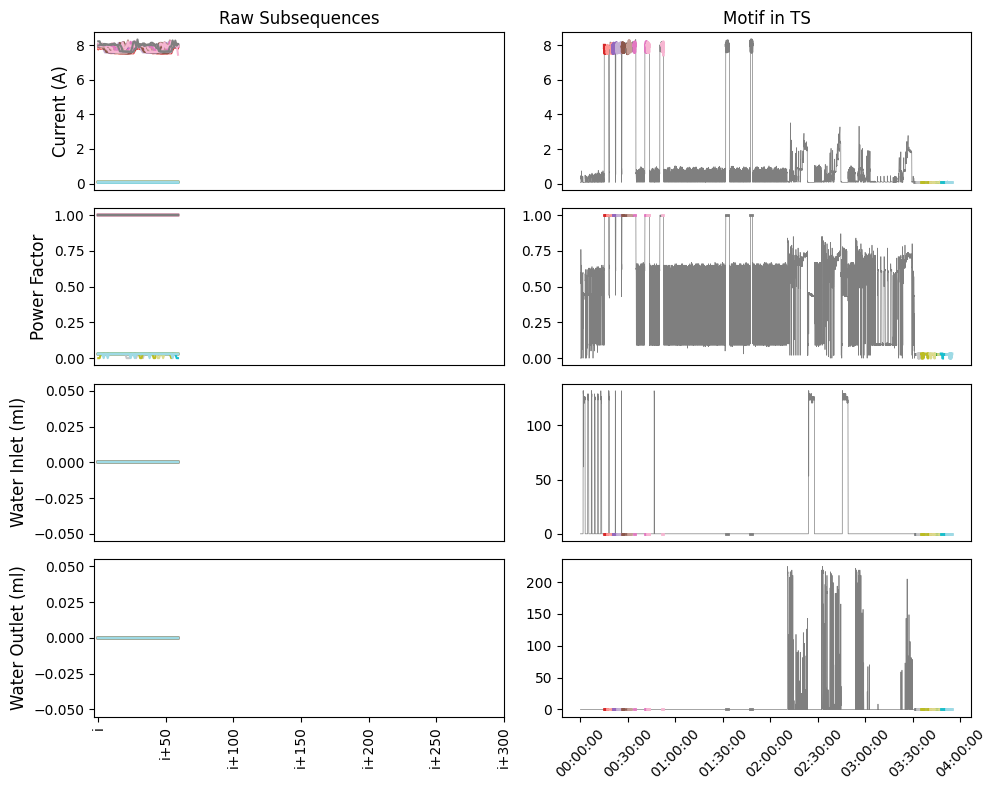

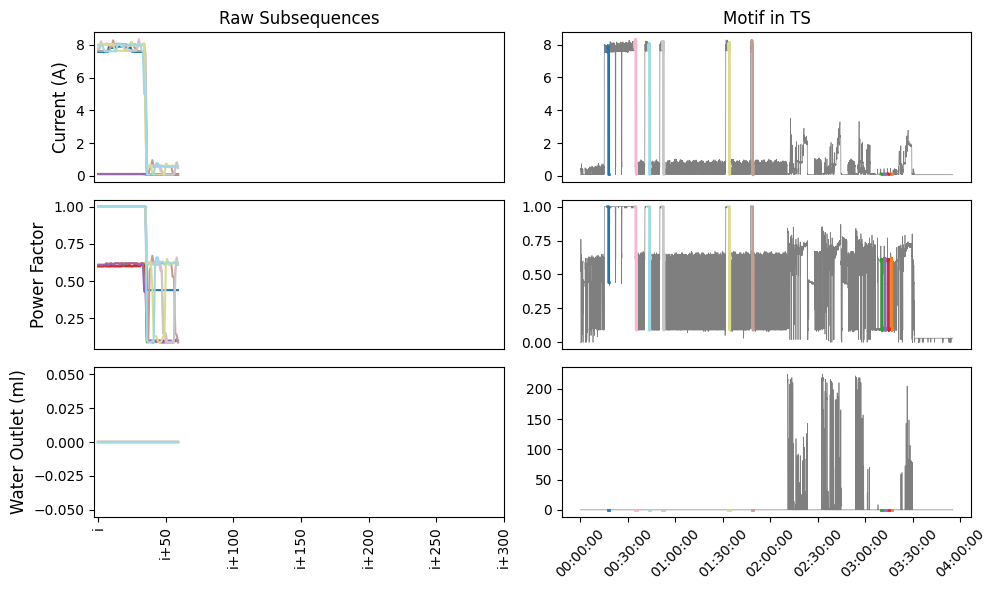

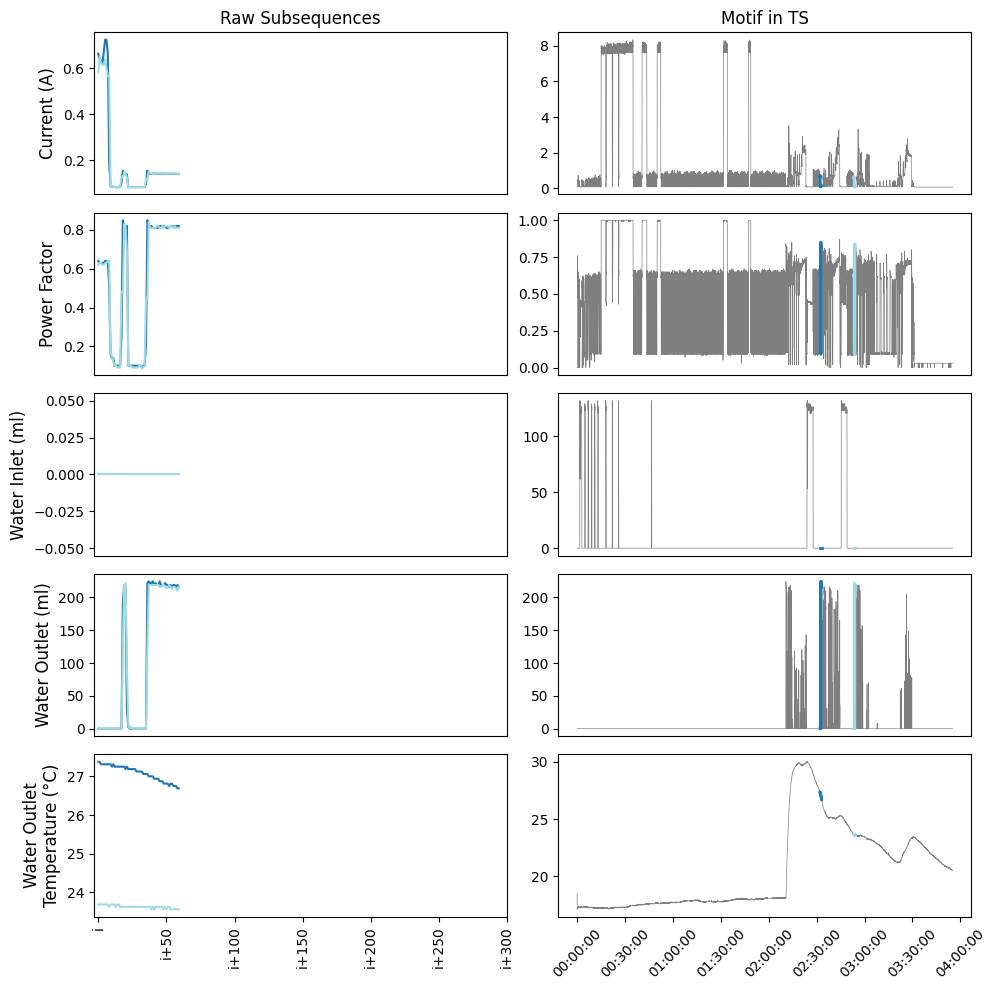

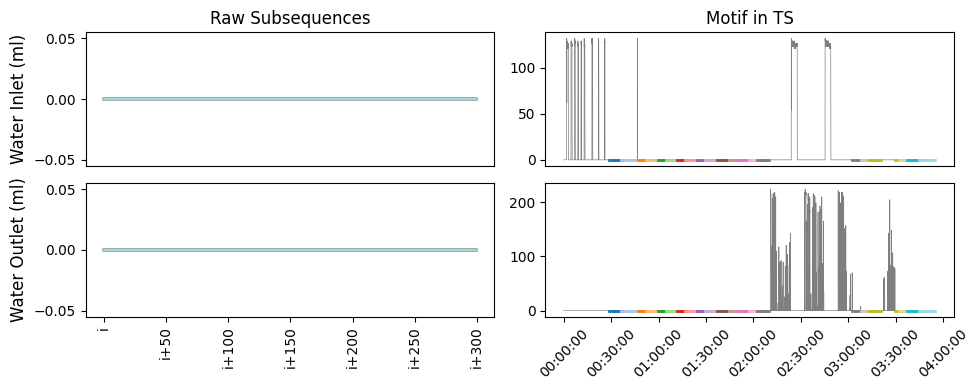

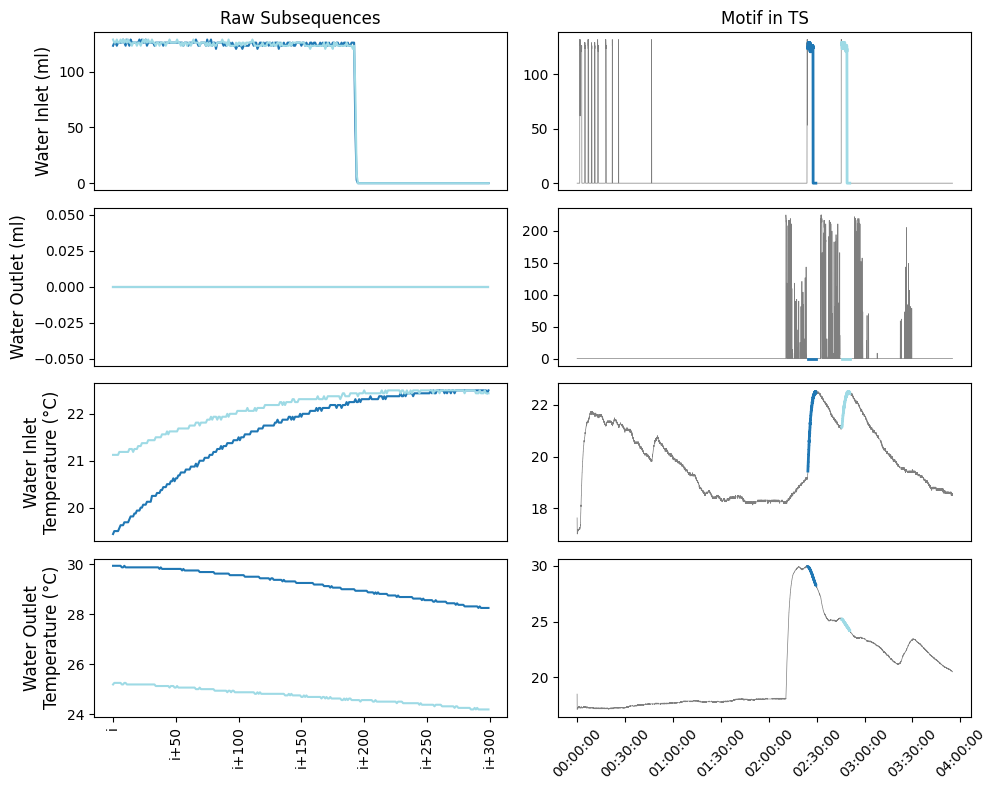

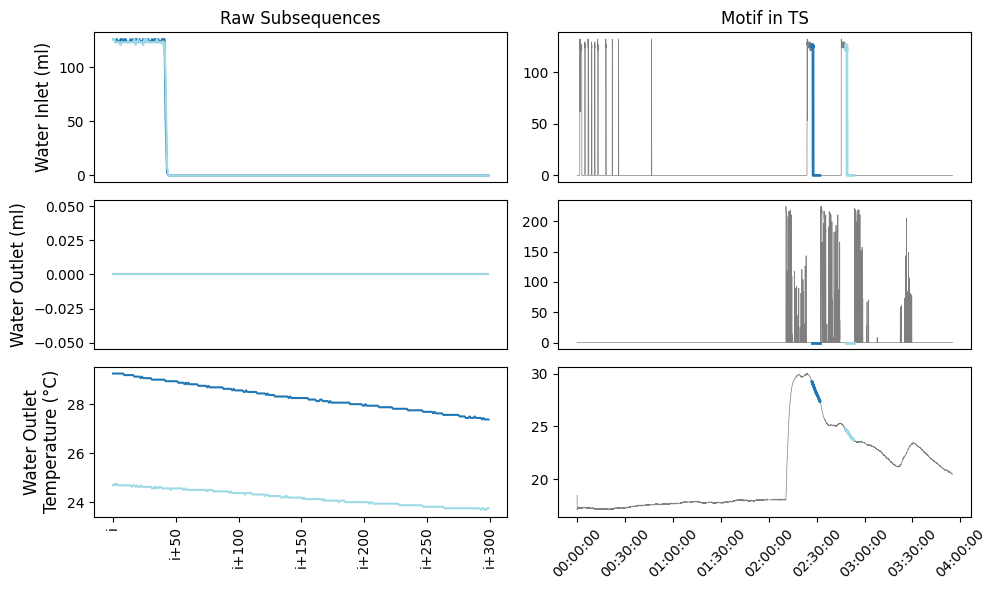

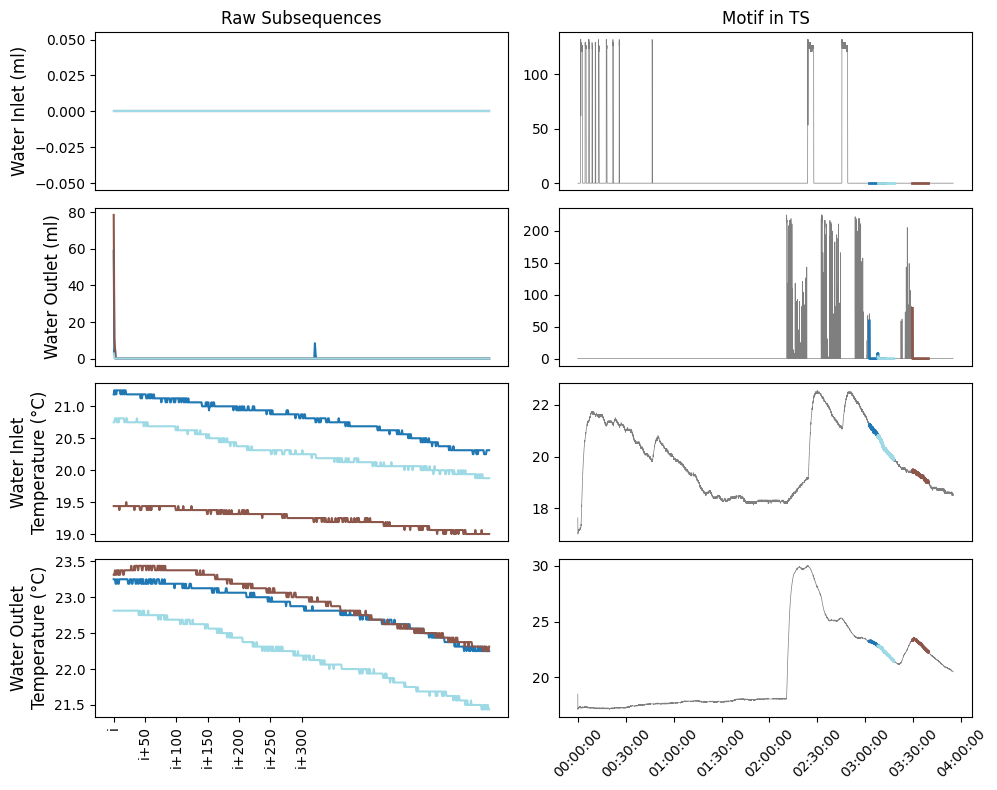

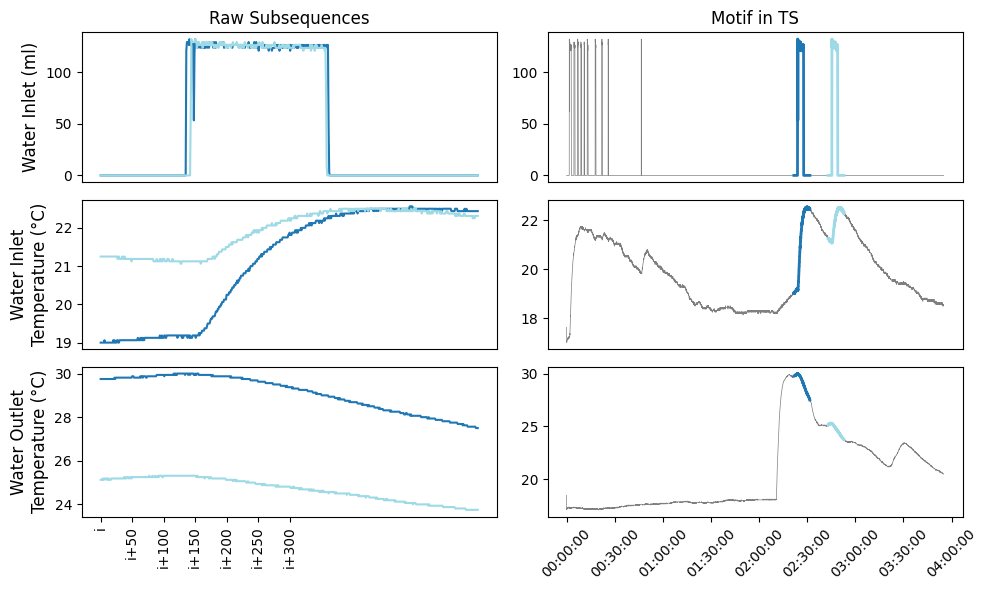

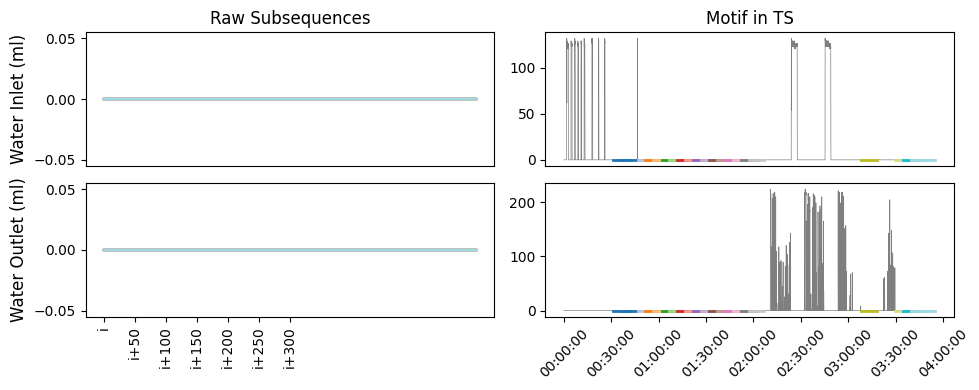

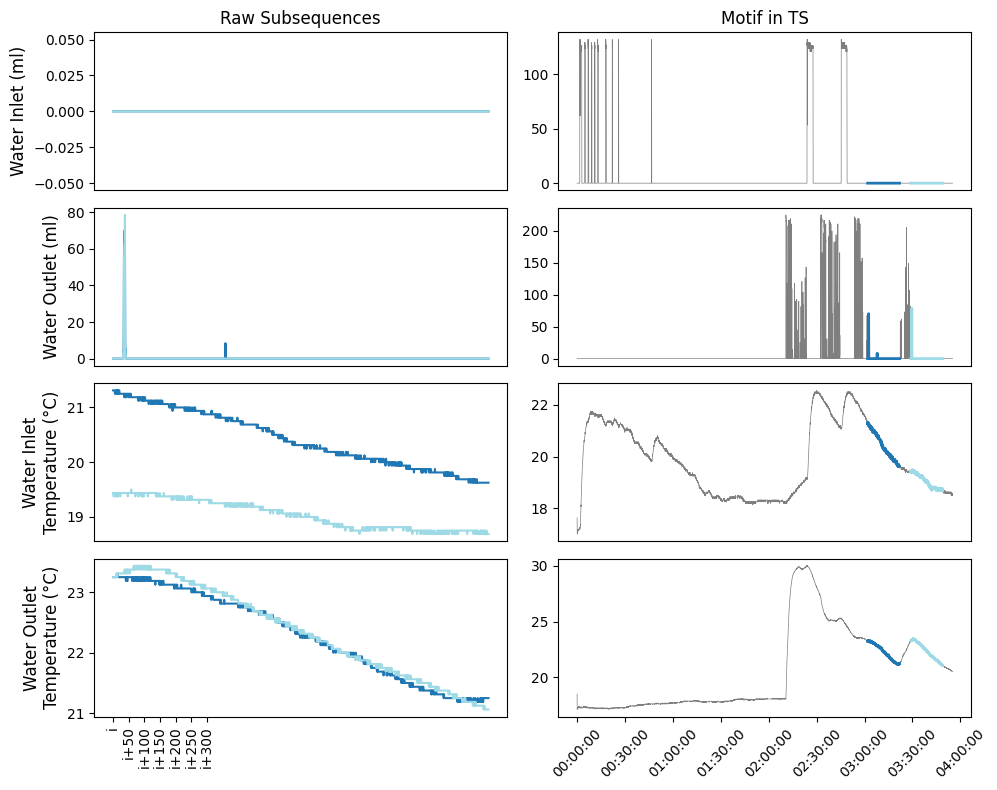

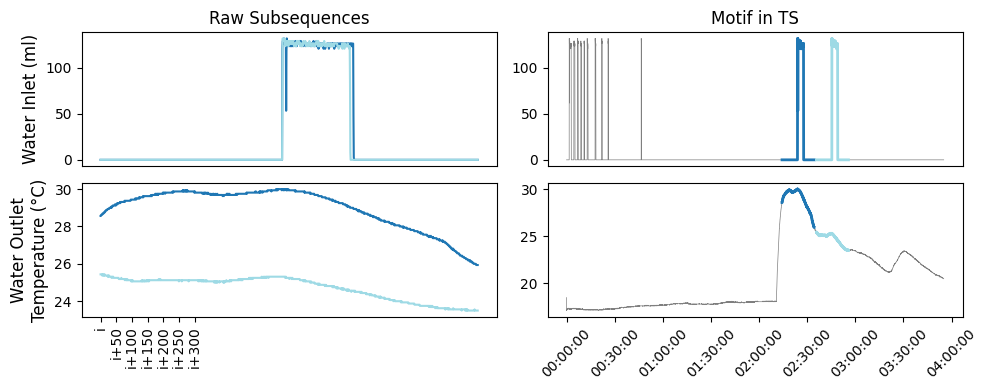

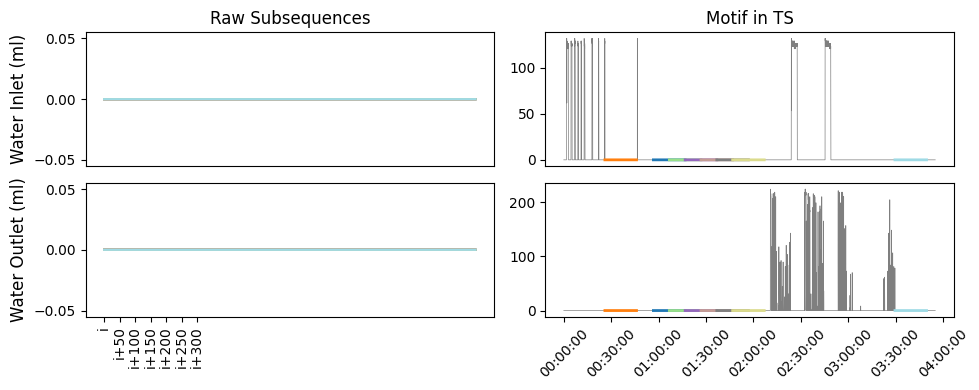

In [15]:
#plot top motif
for m in subsequence_lengths:
    print("Motif length: ", m)
    top_motifs = mp_stats_table[mp_stats_table["m"] == m]
    top_motifs = top_motifs[top_motifs["k"] > 1].sort_values(by="p-value").head(3)
    for top_motif in top_motifs.to_dict(orient="records"): 
        m = top_motif["m"]
        dimensions = top_motif["Features"].split(",")
        dimensions = sorted([int(dimension) for dimension in dimensions])
        features = [data.columns[dimension] for dimension in dimensions]
        indices = top_motif['Indices'].replace("[","").replace("]","").split(",")
        indices = [int(i) for i in indices]
        motif_name = top_motif["ID"]
        ts_list = [data[feature] for feature in features]
        plot_motif(ts_list, features, m, indices, motif_name)